<img src="../../img/weather.png" alt="" style="width: 100%; border-radius: 20px;"/>

## Objective
The primary goal of this notebook is to integrate weather data at each bird sighting location, as recorded on *ornitho.ch* and *ornitho.de*, utilizing the provided latitude, longitude coordinates and the date of the bird sighting. 

We anticipate that the integration of weather data could enhance the prediction process of some models. There might be a correlation between certain bird species and specific weather conditions, this data could becomes a crucial element in validating the authenticity of a reported bird sighting.

## Scope
In this notebook, we process a bird dataframe and merge it with weather data to determine the weather conditions at the location of each bird sighting. The functions provided in this notebook enable us to ascertain the weather data at the coordinate.

We initially tried using the Earth Engine API to fetch weather data, but encountered issues with slow response times and potential timeouts due to the large number of API requests required for large dataframes. Therefore, we decided to explore another API that could provide similar results. This approach also encountered the similar problems, but was successful after some patience.

In [42]:
from datetime import datetime, timedelta
from meteostat import Point, Daily

import pandas as pd
import geopandas as gpd
import ee
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# 
<p style='background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;'> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following files are required:
- Dataset with 27 selected species: *[selected_bird_species_with_grids_50km.csv](https://drive.google.com/file/d/1ORv3cRvJpA7PS6YKWqvuQ0E6FdeFo3Z-/view?usp=drive_link)*
- EEA Europe Grids 50km: *[inspire_compatible_grid_50km.shp](https://drive.google.com/drive/folders/1atS5eomHYxX-q_5b8WGqFVDtqP3-d8qP?usp=drive_link)*
- Optional, but recommended: The already generated date-weather-grid dataframe: *[meteo_weather_date_grid.csv](https://drive.google.com/file/d/1iAAUzbC3EpKyPxdmv4SX41d578S1Ndd9/view?usp=drive_link)*

If you wish to store the resulting dataframe enriched with the land cover data, please specify a target path.

In [37]:
df_path = r'D:\\Simon\\Documents\\GP\\data\\datasets\\selected_bird_species_with_grids_50km.csv'
meteo_path = r'D:\\Simon\\Documents\\GP\\data\\datasets\\meteo_weather_date_grid.csv'
eea_shapefile_path = r'D:\\Simon\\Documents\\GP\data\\util_files\\eea_grid_files\\eea_europe_grids_50km\\inspire_compatible_grid_50km.shp'
target_path = r'D:\\Simon\\Documents\\GP\\data\\datasets\\selected_bird_species_grids_weather.csv'

# 
<p style='background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;'> &nbsp; 1️⃣ Load data </p>

In this notebook, we compute the weather for all given sightings from 2018-2022.
For this we need to load the EEA Shapefile and our existing dataframe.
When loading the meteo dataframe it will speed up the process a lot.

In [33]:
eea_grid = gpd.read_file(eea_shapefile_path)
eea_grid = eea_grid.to_crs('EPSG:4326')

In [34]:
df = pd.read_csv(df_path, index_col=0, low_memory=False)
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head(5)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1,0.0,0,37718.0,de,50kmE4200N3300
1,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,1,2.0,0,37803.0,de,50kmE4250N3300
2,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,269,2.0,0,39627.0,de,50kmE4450N3050
3,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,157,8.0,0,38301.0,de,50kmE4350N3100
4,29656211,8.0,Haubentaucher,2018-01-01,NaN,51.389380,7.067282,place,52,10.0,0,108167.0,de,50kmE4100N3100


# 
<p style='background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;'> &nbsp; 2️⃣ Weather data generation </p>

In our analysis, we've explored two different approaches to fetch and integrate weather data for each bird sighting location. 

- **Preparation:** To make the process more efficient and reduce the number of API requests, we use a grid system. The provided code first defines a bounding box for Germany and Switzerland and filters a grid to only include cells that intersect with this bounding box. For each cell in the filtered grid, the code calculates the centroid (geometric center) of the cell and adds the coordinates of the centroid to the dataframe.
The code then creates a range of dates (all days from 2018 - 2022) and generates a dataframe that includes all combinations of dates and grid cell IDs. This dataframe serves as the basis for fetching the weather data with the following approaches.

- **Earth Engine API:** The first approach utilizes the Earth Engine API. This method involves fetching the mean weather data for the specified date and location. The weather data fetched includes precipitable water in the entire atmosphere, relative humidity 2m above ground, specific humidity 2m above ground, temperature 2m above ground, and the u and v components of wind 10m above ground. 

- **Meteostat API:** The second approach uses another API, Meteostat, to fetch daily weather data for a given location and date. This method is applied to each row of our dataframe, adding columns for average temperature, minimum temperature, maximum temperature, precipitation, snowfall, wind direction, wind speed, peak gust, pressure, and sunshine duration.

Both of these approaches provide a similar outcome and could deliver valuable insights into the relationship between bird sightings and weather conditions, and can significantly enhance the predictive power of our existing models.

## Preparation: Create a grid and date combination dataframe

The following steps were performed:

- **Geographical Filtering:** A geographical bounding box for Germany and Switzerland was defined. The grid was then filtered to only include cells within this bounding box.

- **Centroid Calculation:** For each cell in the filtered grid, the geometric center, or centroid, was calculated. The coordinates of the centroid were added to the dataframe.

- **Date Range Creation:** A range of dates from 2018 to 2022 was created.

- **Combination Generation:** A dataframe was generated that includes all combinations of dates and grid cell IDs. This dataframe forms the basis for fetching the weather data.

In summary, the process involved defining a geographical area of interest, calculating the centroid for each grid cell within this area, and generating a comprehensive dataframe of all combinations of dates and grid cell IDs. This dataframe is later used to fetch weather data using two different APIs.

In [10]:
germany_switzerland_bbox = eea_grid.cx[5.210942:15.669926, 45.614516:55.379499]
eea_grid_filtered = eea_grid[eea_grid.intersects(germany_switzerland_bbox.unary_union)]
eea_grid_filtered.reset_index(drop=True, inplace=True)

centroid_gdf = eea_grid_filtered.copy()
centroid_gdf['centroid'] = eea_grid_filtered['geometry'].centroid

centroid_gdf['centroid_lon'] = centroid_gdf['centroid'].x
centroid_gdf['centroid_lat'] = centroid_gdf['centroid'].y
centroid_gdf.drop(columns=['geometry', 'noforigin', 'eoforigin', 'gid', 'centroid'], inplace=True)
centroid_gdf.rename(columns={'cellcode': 'eea_grid_id'}, inplace=True)

In [11]:
eea_grid_id = centroid_gdf.eea_grid_id
lat = centroid_gdf.centroid_lat
lon = centroid_gdf.centroid_lon

start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2022-12-31')
date = pd.date_range(start_date, end_date)

all_combinations = pd.MultiIndex.from_product([date, eea_grid_id], names=['date', 'eea_grid_id'])
all_combinations = pd.DataFrame(index=all_combinations).reset_index()
all_combinations = pd.merge(all_combinations, centroid_gdf[['eea_grid_id', 'centroid_lat', 'centroid_lon']], on='eea_grid_id', how='right')
all_combinations.head(5)    

,date,eea_grid_id,centroid_lat,centroid_lon
0,2018-01-01,50kmE3850N2450,45.234056,4.323137
1,2018-01-02,50kmE3850N2450,45.234056,4.323137
2,2018-01-03,50kmE3850N2450,45.234056,4.323137
3,2018-01-04,50kmE3850N2450,45.234056,4.323137
4,2018-01-05,50kmE3850N2450,45.234056,4.323137


## 1st approach: *Earth Engine*
<img src="https://www.appgeo.com/wp-content/uploads/GoogleEarthEngine.png" alt="Google Earth Engine Icon" style="border-radius: 7px; width: 300px; height: auto;">

Earth Engine is a cloud-based platform developed by Google that provides access to a vast amount of geospatial data and computational resources for analyzing and visualizing Earth's surface [1].

In the context of extracting weather data based on latitude and longitude values for Europe, Earth Engine can be utilized to access and process high-resolution weather datasets. These datasets provide information about various weather conditions at different geographic locations.

Contrary to other APIs, Earth Engine utilizes Google's cloud infrastructure, providing significant computational resources for large-scale geospatial analyses.

The first approach to fetch and integrate weather data for each bird sighting location utilizes Google’s Earth Engine. Earth Engine is a cloud-based platform that provides access to a vast amount of geospatial data and computational resources for analyzing and visualizing Earth’s surface. It is particularly useful for large-scale geospatial analyses due to its comprehensive coverage and frequent updates.

### Generation
The process of querying a weather value for a sighting is similar to other APIs - Earth Engine also requires separate API requests for each individual bird sighting. The code provided for this approach fetches the mean weather data for the specified date and location using the Earth Engine API. It then merges the fetched weather data with the bird sightings data based on the date and grid cell ID. The resulting dataframe, which includes the date, grid cell ID, and weather data for each combination, can now be used for further analysis or modeling.

By fetching the weather data for a grid of coordinates instead of individual sightings, we can significantly reduce the number of API calls. We can then assign the weather data to each bird sighting based on which grid cell the sighting falls into. This approach is more efficient and scalable for large datasets.

#### The NOAA/GFS0P25 dataset
The NOAA/GFS0P25 dataset is part of the Global Forecast System (GFS), a weather forecast model by the National Centers for Environmental Prediction (NCEP). The GFS provides a variety of weather data, including temperatures, winds, precipitation, soil moisture, and atmospheric ozone concentration [2].

The GFS covers the entire globe and is updated four times daily. It provides forecasts up to 16 days in the future, with varying resolutions based on the forecast range [2].

This dataset is particularly useful for large-scale geospatial analyses due to its comprehensive coverage and frequent updates [2].


<img src="https://www.ncei.noaa.gov/pub/data/metadata/images/noaa_logo.jpg" alt="NOAA Icon" style="border-radius: 7px; width: 200px; height: auto;">


### Developer disclaimer
Running the following code takes more than 10 hours. The weather data has to be fetched for all grids for all dates from 2018 to 2022, which amounts to 796,136 API calls.
In the final calculation of the weather feature, we do not use Google Earth Engine. Therefore, in order to create the weather feature for a dataframe, you are not required to be able to run the following code.

However, if you wish to run it anyway, follow these steps to authenticate to Google Earth Engine:


**1. Set up a Google Earth Engine Account:**
- Before you can use Google Earth Engine, you need to sign up for an account at https://earthengine.google.com/signup/.
- Follow the steps to create an account and agree to the terms and conditions. Create a new Google Cloud Project project with a name of your choice.
- Provide the project name in the `your_project_name` variable below.

In [12]:
your_project_name = 'ee-simonbirk'

**2. Authenticate to Earth Engine:**
- Authenticate your account by running the following code.
- Follow the instructions that appear in the console. This will involve opening a link in your web browser, and signing in with your Google account. You may also need to paste a provided authorization token if requested by Google.

In [13]:
ee.Authenticate()
ee.Initialize(project=your_project_name)

**3. Run the following code:**
- Once authenticated, you can run the following code to retrieve weather data:

In [90]:
def get_weather_data_ee(dataset, date, lat, lon):
    point = ee.Geometry.Point([lon, lat])
    start_date = ee.Date(date)
    end_date = start_date.advance(1, 'day')
    imageCollection = ee.ImageCollection(dataset).filterDate(start_date, end_date)
    firstImage = imageCollection.first()
    imageCollection = imageCollection.map(lambda image: image.select(firstImage.bandNames()))
    image = imageCollection.mean()
    data = image.reduceRegion(ee.Reducer.mean(), point, 500)
    data = data.getInfo()
    return data

> **Caution:** the next cell has a runtime of 10h! -> it is recommended to continue with the next approach

In [93]:
weather_data_list = all_combinations.apply(lambda row: get_weather_data_ee("NOAA/GFS0P25", row['date'], row['centroid_lat'], row['centroid_lon']), axis=1)
weather_data_list = pd.json_normalize(weather_data_list)
ee_weather_date_grid = pd.concat([all_combinations, weather_data_list], axis=1)

In [108]:
ee_weather_date_grid['date'] = pd.to_datetime(ee_weather_date_grid['date'])
df['date'] = pd.to_datetime(df['date'])

merged_df = pd.merge(df, ee_weather_date_grid, on=['eea_grid_id', 'date'])

### Issues
Despite Earth Engine providing a robust geospatial analysis platform with extensive computational resources, the processing duration is really long.

## 2nd Approach: Meteostat API

*Meteostat* is a widely-used external API for obtaining weather data in scientific and geospatial analyses. It does not require any authentication or registration, making it accessible for developers to run this script.

Meteostat provides a straightforward API for querying weather information based on latitude and longitude coordinates. It uses global datasets to provide weather values, making it suitable for a wide range of locations.

### Generation
To generate weather data, Meteostat requires the latitude, longitude and date of the bird sighting. Since there is no option to pass a batch or list of multiple sightings at once, the API must be queried for each sighting individually. The fetched weather data includes average temperature, minimum temperature, maximum temperature, precipitation, snowfall, wind direction, wind speed, peak gust, pressure, and sunshine duration.

The `fetch_weather_meteostat` function is applied to each row of the dataframe. This function fetches the daily weather data for the centroid of each grid cell on each date in the date range. The results are stored in a new dataframe, adding the weather data as separate columns.

By fetching the weather data for a grid of coordinates instead of individual sightings, we can significantly reduce the number of API calls. We can then assign the weather data to each bird sighting based on which grid cell the sighting falls into. This approach is more efficient and scalable for large datasets.

### Disclaimer
Running the code to fetch the weather data takes about 10 hours. The weather data is fetched for all grids from 2018 to 2022, which amounts to 796,136 API calls. You can skip to the next cell.

In [86]:
def fetch_weather_meteostat(row):
    location = Point(row['centroid_lat'], row['centroid_lon'])
    data = Daily(location, row['date'], row['date']).fetch()
    if data.empty:
        return None
    return data.iloc[0]

> **Caution:** the next cell has a runtime of 10h! -> use the cell after this to load the already computed *meteo_weather_date_grid* to continue.

In [48]:
weather_data_list = all_combinations.apply(fetch_weather_meteostat, axis=1)
meteo_weather_date_grid = all_combinations.copy()
meteo_weather_date_grid[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']] = pd.DataFrame(weather_data_list, index=meteo_weather_date_grid.index)

In [110]:
meteo_weather_date_grid = pd.read_csv(meteo_path, index_col=0, low_memory=False)
meteo_weather_date_grid['date'] = pd.to_datetime(meteo_weather_date_grid['date'])

In [111]:
meteo_weather_date_grid['date'] = pd.to_datetime(meteo_weather_date_grid['date'])
df['date'] = pd.to_datetime(df['date'])

merged_df = pd.merge(df, meteo_weather_date_grid, on=['eea_grid_id', 'date'])
merged_df.head(5)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1,0.0,...,6.5,3.2,9.2,2.1,0.0,212.0,24.8,68.4,997.2,174.0
1,29935940,8.0,Haubentaucher,2018-01-01,NaN,53.111830,8.828814,place,0,15.0,...,6.5,3.2,9.2,2.1,0.0,212.0,24.8,68.4,997.2,174.0
2,29662711,8.0,Haubentaucher,2018-01-01,NaN,53.168290,8.367643,place,-1,1.0,...,6.5,3.2,9.2,2.1,0.0,212.0,24.8,68.4,997.2,174.0
3,29664243,338.0,Mittelspecht,2018-01-01,NaN,53.184689,8.248539,place,14,1.0,...,6.5,3.2,9.2,2.1,0.0,212.0,24.8,68.4,997.2,174.0
4,29662059,463.0,Wiesenpieper,2018-01-01,NaN,53.211597,8.304432,place,-1,5.0,...,6.5,3.2,9.2,2.1,0.0,212.0,24.8,68.4,997.2,174.0


In [38]:
merged_df.to_csv(target_path)

### Issues
While the Meteostat API approach has been effective in generating weather data for our analysis, there are a few challenges and considerations to note:

- **Performance:** The process of fetching weather data for all grids from 2018 to 2022 is time-consuming due to the large number of API calls required (796,136 in total). This results in a slower response time, which could impact the efficiency of the analysis.

- **Data Completeness:** Despite the comprehensive coverage of the Meteostat API, there are instances where weather data could not be generated for certain rows. This could be due to various factors such as the unavailability of weather data for specific dates or locations. This limitation could potentially impact the completeness of the weather feature in our dataset.

## Summary and Conclusion
In the process of calculating weather for each bird sighting from ornitho.de and ornitho.ch based on the bird’s location, two distinct approaches were employed:

The first approach utilizes the Earth Engine API. This method involves fetching the mean weather data for the specified date and location. 

The second approach uses the Meteostat API to fetch daily weather data for a given location and date. 

Both of these approaches provide a similar outcome and could deliver valuable insights into the relationship between bird sightings and weather conditions, and can significantly enhance the predictive power of our existing models.


<img src='../../img/weather_generation_overview.png' alt='Weather overview' style='width: 100%; border-radius: 20px;'/>

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Initial assessment of the weather feature</p>

In this chapter, the primary objective is to conduct an initial assessment of the potential decision support provided by the inclusion of weather as a feature in our bird species analysis. We aim to explore how incorporating weather data information might enhance the overall ability of our models of detecting implausible bird sightings.

It is crucial to note that the model-based evaluation of the efficacy of this feature will be thoroughly examined in a subsequent evaluation, integrated with the deployed models, as part of the *Hauptprojekt*.

## Temperature range by species
The first plot we will discuss represents the temperature at which different bird species have been sighted. This is visualized as a boxplot with temperature on one axis and species on the other.

From this plot, we can observe some interesting patterns:

- Certain species, such as the **Gänsegeier** and **Karmingimpel**, tend to be spotted more frequently at temperatures above 5°C. This could suggest that these species are more active or visible in these temperature conditions.

- The median temperature for most species is roughly the same, indicating that a large number of bird sightings occur under similar temperature conditions. However, upon closer inspection, we can spot some minor differences between species. These differences could be due to various factors such as the bird's habitat, behavior, or migration patterns.

These observations could have significant implications for our predictive models. If certain bird species are more likely to be seen at specific temperatures, this information could enhance the accuracy of our bird sighting predictions. Furthermore, understanding the relationship between bird sightings and temperature could also aid in the validation of reported bird sightings.

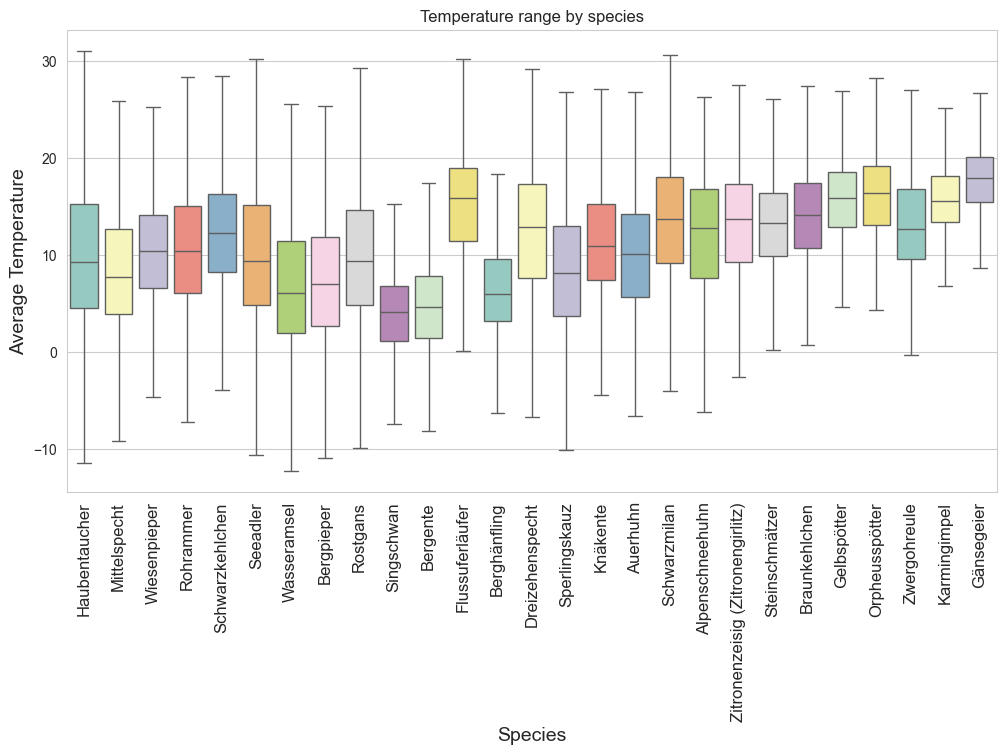

In [115]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x='name_species', y='tavg', data=merged_df, palette="Set3", showfliers=False)
plt.xlabel('Species', fontsize=14)
plt.ylabel('Average Temperature', fontsize=14)
plt.title('Temperature range by species')
plt.xticks(rotation=90, fontsize=12)
plt.show()


## Histogram of Average Temperature for Selected Species

The second plot in our analysis is a histogram that shows the distribution of average temperatures at which different bird species have been sighted. The species plotted are 'Flussuferläufer', 'Schwarzkehlchen', 'Singschwan', 'Steinschmätzer', and 'Gelbspötter'.

From this histogram, we can make several interesting observations:

- **Gelbspötter:** This species is more commonly sighted at temperatures around 10 to 20°C, with a peak at 15°C. Sightings are less common at temperatures of 5°C or lower.

- **Flussuferläufer:** Sightings of this species are most common around 10 to 20°C, but it is also slightly more common around 20°C than the Gelbspötter.

- **Singschwan:** This species is most commonly sighted at temperatures from -0.25 to 7.5°C. Sightings above 10°C are less likely, and at -5°C, it is still the most likely bird of the plotted ones to be sighted.

- **Steinschmätzer:** Sightings of this species are most common from 7.5 to 20°C, but it is not common at 0°C and below.

- **Schwarzkehlchen:** This species seems to have the broadest range of common sightings, mostly from 7.5 to 20°C, but also not much below 0°C.

These observations are based on the temperatures over the year in the habitats where the birds were spotted on those dates. While this is just the temperature over the year in Germany, it is still interesting to see some differences between the species.

These findings could be valuable for our predictive models. Understanding the relationship between bird sightings and temperature could enhance the accuracy of our bird sighting predictions and aid in the validation of reported bird sightings.


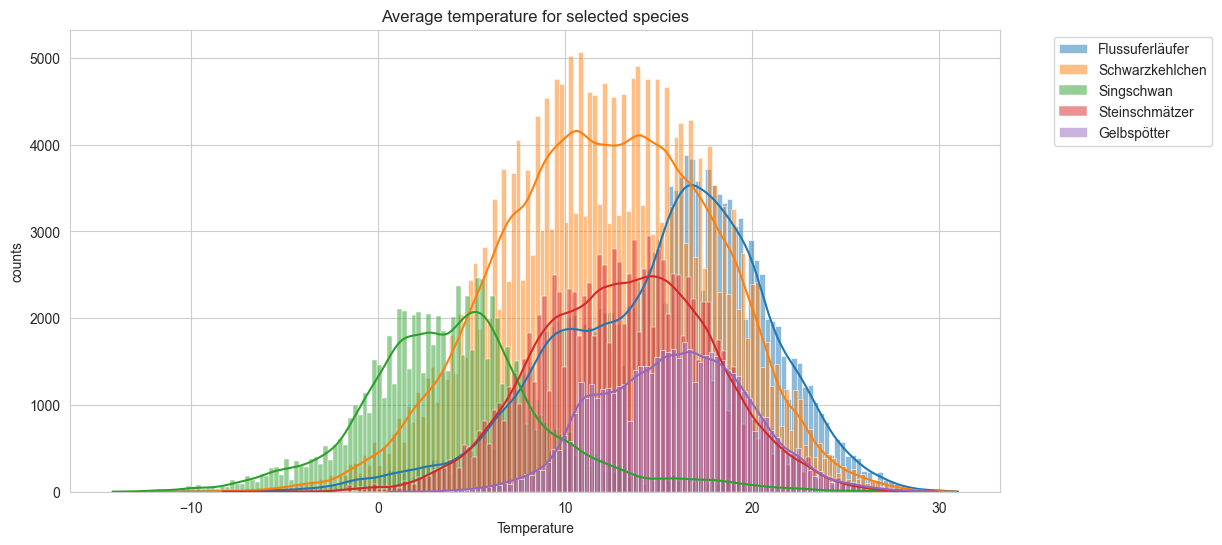

In [128]:
plt.figure(figsize=(12, 6))
species = ['Flussuferläufer','Schwarzkehlchen', 'Singschwan', 'Steinschmätzer', 'Gelbspötter']
for species in species:
    df_species = merged_df[merged_df['name_species'] == species]
    sns.histplot(df_species['tavg'], kde=True, label=species)

plt.xlabel('Temperature')
plt.ylabel('counts')
plt.title('Average temperature for selected species')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# References
[1] https://earthengine.google.com/; Visited 12th Jan 

[2]  https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00631; Visited 12th Jan 2024.

